# XGBoost Most Important

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt 
import seaborn as sns
import ppscore as pps

## Read in and Split Data

In [2]:
# read in data
data = pd.read_csv('../data/business_closures_data.csv')
data.head()

,Percent Change in Number of Small Businesses Open,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% Below Poverty,Median Household Income,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed,Presence of Water Violation (dummy Y/N),Other Primary Care Provider Ratio (:1)
0,-39.70,19089,Iowa,Howard,99,5608.073753,12.622644,3.160173,3.574778,6.971154,...,9.6,58028.0,11.560510,2.8,26.448363,5.143541,31.287879,16.264805,0,1021
1,-1.01,31177,Nebraska,Washington,195,4632.870334,11.720313,2.750393,3.175809,6.013514,...,6.8,75197.0,21.067497,2.9,29.484214,6.721927,32.813006,12.265953,0,1148
2,-5.51,31159,Nebraska,Seward,207,5410.847151,12.026406,2.968235,3.218111,6.212121,...,7.2,72291.0,19.126991,2.9,34.388775,7.529180,33.000000,11.688027,0,4330
3,-1.59,31145,Nebraska,Red Willow,137,6658.414878,14.776613,3.288232,3.690134,6.571742,...,12.0,50260.0,11.779891,2.8,32.797243,11.402280,34.854962,16.237970,0,825
4,-19.20,31141,Nebraska,Platte,309,5279.823593,14.422556,3.001068,3.286868,5.771531,...,9.0,62804.0,14.510795,2.9,30.711008,7.532143,31.196560,10.707512,1,2085


In [3]:
X = data.drop(["FIPS", "Percent Change in Number of Small Businesses Open", "State", "County"], axis=1)
y = pd.DataFrame(data["Percent Change in Number of Small Businesses Open"])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
len(X.columns)

98

## XGBoost and Feature Importance

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [7]:
"""
Hyperparameter Tuning from 
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
"""

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':"rmse"
}

In [8]:
num_boost_round = 999

In [9]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:25.92033
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:20.78537
[2]	Test-rmse:17.46705
[3]	Test-rmse:15.59518
[4]	Test-rmse:14.33676
[5]	Test-rmse:13.72074
[6]	Test-rmse:13.27290
[7]	Test-rmse:13.06592
[8]	Test-rmse:12.86434
[9]	Test-rmse:12.75714
[10]	Test-rmse:12.70227
[11]	Test-rmse:12.70571
[12]	Test-rmse:12.72412
[13]	Test-rmse:12.77911
[14]	Test-rmse:12.76573
[15]	Test-rmse:12.70386
[16]	Test-rmse:12.73252
[17]	Test-rmse:12.78422
[18]	Test-rmse:12.75875
[19]	Test-rmse:12.78296
[20]	Test-rmse:12.77765
Stopping. Best iteration:
[10]	Test-rmse:12.70227



In [10]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,24.122368,0.177963,24.565967,0.796017
1,18.678352,0.241845,19.663661,0.851812
2,15.038077,0.246902,16.771003,0.854767
3,12.639122,0.221484,15.119878,0.766757
4,11.022846,0.211834,14.194710,0.710277
5,9.838983,0.227452,13.741957,0.663787
6,8.993454,0.175431,13.451457,0.651569
7,8.414810,0.084145,13.318151,0.615172
8,7.956826,0.142758,13.231717,0.583604


In [11]:
cv_results['test-rmse-mean'].min()

13.231716599999999

### Tune max_depth and min_child_weight

In [12]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [13]:
# Define initial best params and rmse
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=9, min_child_weight=5
	rmse 13.649931200000001 for 12 rounds
CV with max_depth=9, min_child_weight=6
	rmse 13.672821200000001 for 11 rounds
CV with max_depth=9, min_child_weight=7
	rmse 13.440301 for 9 rounds
CV with max_depth=10, min_child_weight=5
	rmse 13.767038600000001 for 11 rounds
CV with max_depth=10, min_child_weight=6
	rmse 13.766863 for 11 rounds
CV with max_depth=10, min_child_weight=7
	rmse 13.9220958 for 10 rounds
CV with max_depth=11, min_child_weight=5
	rmse 13.706507400000001 for 13 rounds
CV with max_depth=11, min_child_weight=6
	rmse 13.7451216 for 14 rounds
CV with max_depth=11, min_child_weight=7
	rmse 13.715571 for 12 rounds
Best params: 9, 7, rmse: 13.440301


In [14]:
params['max_depth'] = 9
params['min_child_weight'] = 7

### Tune subsample and colsample

In [15]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [16]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	rmse 13.4403008 for 9 rounds
CV with subsample=1.0, colsample=0.9
	rmse 13.592345 for 8 rounds
CV with subsample=1.0, colsample=0.8
	rmse 13.3919556 for 9 rounds
CV with subsample=1.0, colsample=0.7
	rmse 13.380223 for 13 rounds
CV with subsample=0.9, colsample=1.0
	rmse 13.662141 for 7 rounds
CV with subsample=0.9, colsample=0.9
	rmse 13.384115200000002 for 11 rounds
CV with subsample=0.9, colsample=0.8
	rmse 13.594443000000002 for 7 rounds
CV with subsample=0.9, colsample=0.7
	rmse 13.5421364 for 24 rounds
CV with subsample=0.8, colsample=1.0
	rmse 13.714267000000001 for 12 rounds
CV with subsample=0.8, colsample=0.9
	rmse 13.643574599999999 for 11 rounds
CV with subsample=0.8, colsample=0.8
	rmse 13.630904000000001 for 9 rounds
CV with subsample=0.8, colsample=0.7
	rmse 13.5215212 for 10 rounds
CV with subsample=0.7, colsample=1.0
	rmse 13.9165742 for 14 rounds
CV with subsample=0.7, colsample=0.9
	rmse 13.671624600000001 for 8 rounds
CV with su

In [17]:
params['subsample'] = 1.0
params['colsample_bytree'] = 0.7

### Tune eta

In [18]:
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['rmse'], early_stopping_rounds=10)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CV with eta=0.3
	rmse 13.380223 for 13 rounds

CV with eta=0.2
	rmse 13.3076642 for 25 rounds

CV with eta=0.1
	rmse 13.171398 for 38 rounds

CV with eta=0.05
	rmse 12.976812999999998 for 78 rounds

CV with eta=0.01
	rmse 12.953221200000002 for 424 rounds

CV with eta=0.005
	rmse 12.931864200000001 for 819 rounds

Best params: 0.005, rmse: 12.931864200000001


In [19]:
params['eta'] = .005

In [20]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:33.71524
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:33.57681
[2]	Test-rmse:33.44136
[3]	Test-rmse:33.30759
[4]	Test-rmse:33.17323
[5]	Test-rmse:33.04281
[6]	Test-rmse:32.91023
[7]	Test-rmse:32.77922
[8]	Test-rmse:32.64849
[9]	Test-rmse:32.51883
[10]	Test-rmse:32.38770
[11]	Test-rmse:32.26115
[12]	Test-rmse:32.13264
[13]	Test-rmse:32.00613
[14]	Test-rmse:31.87977
[15]	Test-rmse:31.75391
[16]	Test-rmse:31.62951
[17]	Test-rmse:31.50505
[18]	Test-rmse:31.38393
[19]	Test-rmse:31.26477
[20]	Test-rmse:31.14005
[21]	Test-rmse:31.01794
[22]	Test-rmse:30.90043
[23]	Test-rmse:30.77739
[24]	Test-rmse:30.66070
[25]	Test-rmse:30.54504
[26]	Test-rmse:30.42595
[27]	Test-rmse:30.31303
[28]	Test-rmse:30.19690
[29]	Test-rmse:30.08143
[30]	Test-rmse:29.96850
[31]	Test-rmse:29.85268
[32]	Test-rmse:29.73985
[33]	Test-rmse:29.62782
[34]	Test-rmse:29.51698
[35]	Test-rmse:29.40350
[36]	Test-rmse:29.29043
[37]	Test-rmse:29.18088
[38]	Test-rmse:29.07016
[39]	Test-rmse:28

[330]	Test-rmse:14.37745
[331]	Test-rmse:14.36218
[332]	Test-rmse:14.34664
[333]	Test-rmse:14.33078
[334]	Test-rmse:14.31464
[335]	Test-rmse:14.30057
[336]	Test-rmse:14.28653
[337]	Test-rmse:14.27305
[338]	Test-rmse:14.25773
[339]	Test-rmse:14.24331
[340]	Test-rmse:14.23112
[341]	Test-rmse:14.21724
[342]	Test-rmse:14.20241
[343]	Test-rmse:14.18713
[344]	Test-rmse:14.17397
[345]	Test-rmse:14.16260
[346]	Test-rmse:14.14894
[347]	Test-rmse:14.13419
[348]	Test-rmse:14.12089
[349]	Test-rmse:14.10535
[350]	Test-rmse:14.09232
[351]	Test-rmse:14.08156
[352]	Test-rmse:14.06720
[353]	Test-rmse:14.05278
[354]	Test-rmse:14.03803
[355]	Test-rmse:14.02307
[356]	Test-rmse:14.00832
[357]	Test-rmse:13.99501
[358]	Test-rmse:13.98462
[359]	Test-rmse:13.97039
[360]	Test-rmse:13.95860
[361]	Test-rmse:13.94491
[362]	Test-rmse:13.93188
[363]	Test-rmse:13.91934
[364]	Test-rmse:13.90594
[365]	Test-rmse:13.89455
[366]	Test-rmse:13.88182
[367]	Test-rmse:13.86913
[368]	Test-rmse:13.85790
[369]	Test-rmse:13.84618


[658]	Test-rmse:12.42460
[659]	Test-rmse:12.42285
[660]	Test-rmse:12.42109
[661]	Test-rmse:12.41952
[662]	Test-rmse:12.41808
[663]	Test-rmse:12.41511
[664]	Test-rmse:12.41346
[665]	Test-rmse:12.41175
[666]	Test-rmse:12.41075
[667]	Test-rmse:12.40924
[668]	Test-rmse:12.40820
[669]	Test-rmse:12.40747
[670]	Test-rmse:12.40590
[671]	Test-rmse:12.40459
[672]	Test-rmse:12.40276
[673]	Test-rmse:12.40136
[674]	Test-rmse:12.39940
[675]	Test-rmse:12.39808
[676]	Test-rmse:12.39743
[677]	Test-rmse:12.39705
[678]	Test-rmse:12.39629
[679]	Test-rmse:12.39556
[680]	Test-rmse:12.39377
[681]	Test-rmse:12.39185
[682]	Test-rmse:12.38914
[683]	Test-rmse:12.38731
[684]	Test-rmse:12.38671
[685]	Test-rmse:12.38475
[686]	Test-rmse:12.38362
[687]	Test-rmse:12.38311
[688]	Test-rmse:12.38240
[689]	Test-rmse:12.38307
[690]	Test-rmse:12.38196
[691]	Test-rmse:12.37993
[692]	Test-rmse:12.37873
[693]	Test-rmse:12.37718
[694]	Test-rmse:12.37393
[695]	Test-rmse:12.37399
[696]	Test-rmse:12.37188
[697]	Test-rmse:12.37091


[986]	Test-rmse:12.17011
[987]	Test-rmse:12.16984
[988]	Test-rmse:12.16930
[989]	Test-rmse:12.16873
[990]	Test-rmse:12.16899
[991]	Test-rmse:12.16857
[992]	Test-rmse:12.16792
[993]	Test-rmse:12.16700
[994]	Test-rmse:12.16651
[995]	Test-rmse:12.16653
[996]	Test-rmse:12.16596
[997]	Test-rmse:12.16574
[998]	Test-rmse:12.16557


In [21]:
print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best RMSE: 12.17 in 999 rounds


### Get and save best model

In [22]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-rmse:33.71524
[1]	Test-rmse:33.57681
[2]	Test-rmse:33.44136
[3]	Test-rmse:33.30759
[4]	Test-rmse:33.17323
[5]	Test-rmse:33.04281
[6]	Test-rmse:32.91023
[7]	Test-rmse:32.77922
[8]	Test-rmse:32.64849
[9]	Test-rmse:32.51883
[10]	Test-rmse:32.38770
[11]	Test-rmse:32.26115
[12]	Test-rmse:32.13264
[13]	Test-rmse:32.00613
[14]	Test-rmse:31.87977
[15]	Test-rmse:31.75391
[16]	Test-rmse:31.62951
[17]	Test-rmse:31.50505
[18]	Test-rmse:31.38393
[19]	Test-rmse:31.26477
[20]	Test-rmse:31.14005
[21]	Test-rmse:31.01794
[22]	Test-rmse:30.90043
[23]	Test-rmse:30.77739
[24]	Test-rmse:30.66070
[25]	Test-rmse:30.54504
[26]	Test-rmse:30.42595
[27]	Test-rmse:30.31303
[28]	Test-rmse:30.19690
[29]	Test-rmse:30.08143
[30]	Test-rmse:29.96850
[31]	Test-rmse:29.85267
[32]	Test-rmse:29.73985
[33]	Test-rmse:29.62782
[34]	Test-rmse:29.51698
[35]	Test-rmse:29.40350
[36]	Test-rmse:29.29043
[37]	Test-rmse:29.18088
[38]	Test-rmse:29.07016
[39]	Test-rmse:28.96413
[40]	Test-rmse:28.85504
[41]	Test-rmse:28.74576
[4

[333]	Test-rmse:14.33078
[334]	Test-rmse:14.31464
[335]	Test-rmse:14.30057
[336]	Test-rmse:14.28653
[337]	Test-rmse:14.27305
[338]	Test-rmse:14.25773
[339]	Test-rmse:14.24331
[340]	Test-rmse:14.23112
[341]	Test-rmse:14.21724
[342]	Test-rmse:14.20241
[343]	Test-rmse:14.18713
[344]	Test-rmse:14.17397
[345]	Test-rmse:14.16260
[346]	Test-rmse:14.14894
[347]	Test-rmse:14.13419
[348]	Test-rmse:14.12089
[349]	Test-rmse:14.10535
[350]	Test-rmse:14.09232
[351]	Test-rmse:14.08156
[352]	Test-rmse:14.06720
[353]	Test-rmse:14.05278
[354]	Test-rmse:14.03803
[355]	Test-rmse:14.02307
[356]	Test-rmse:14.00832
[357]	Test-rmse:13.99501
[358]	Test-rmse:13.98462
[359]	Test-rmse:13.97039
[360]	Test-rmse:13.95860
[361]	Test-rmse:13.94491
[362]	Test-rmse:13.93188
[363]	Test-rmse:13.91934
[364]	Test-rmse:13.90594
[365]	Test-rmse:13.89455
[366]	Test-rmse:13.88182
[367]	Test-rmse:13.86913
[368]	Test-rmse:13.85790
[369]	Test-rmse:13.84618
[370]	Test-rmse:13.83567
[371]	Test-rmse:13.82427
[372]	Test-rmse:13.81237


[661]	Test-rmse:12.41952
[662]	Test-rmse:12.41808
[663]	Test-rmse:12.41511
[664]	Test-rmse:12.41346
[665]	Test-rmse:12.41175
[666]	Test-rmse:12.41075
[667]	Test-rmse:12.40924
[668]	Test-rmse:12.40820
[669]	Test-rmse:12.40747
[670]	Test-rmse:12.40590
[671]	Test-rmse:12.40459
[672]	Test-rmse:12.40276
[673]	Test-rmse:12.40136
[674]	Test-rmse:12.39940
[675]	Test-rmse:12.39808
[676]	Test-rmse:12.39743
[677]	Test-rmse:12.39705
[678]	Test-rmse:12.39629
[679]	Test-rmse:12.39556
[680]	Test-rmse:12.39377
[681]	Test-rmse:12.39185
[682]	Test-rmse:12.38914
[683]	Test-rmse:12.38731
[684]	Test-rmse:12.38671
[685]	Test-rmse:12.38475
[686]	Test-rmse:12.38362
[687]	Test-rmse:12.38311
[688]	Test-rmse:12.38240
[689]	Test-rmse:12.38307
[690]	Test-rmse:12.38196
[691]	Test-rmse:12.37993
[692]	Test-rmse:12.37873
[693]	Test-rmse:12.37718
[694]	Test-rmse:12.37393
[695]	Test-rmse:12.37399
[696]	Test-rmse:12.37188
[697]	Test-rmse:12.37091
[698]	Test-rmse:12.37006
[699]	Test-rmse:12.36736
[700]	Test-rmse:12.36569


[989]	Test-rmse:12.16873
[990]	Test-rmse:12.16899
[991]	Test-rmse:12.16857
[992]	Test-rmse:12.16792
[993]	Test-rmse:12.16700
[994]	Test-rmse:12.16651
[995]	Test-rmse:12.16653
[996]	Test-rmse:12.16596
[997]	Test-rmse:12.16574
[998]	Test-rmse:12.16557


In [23]:
best_model.save_model("my_model.model")

In [24]:
(mean_squared_error(best_model.predict(dtest), y_test))**.5

12.165567052291353

### Feature Importance

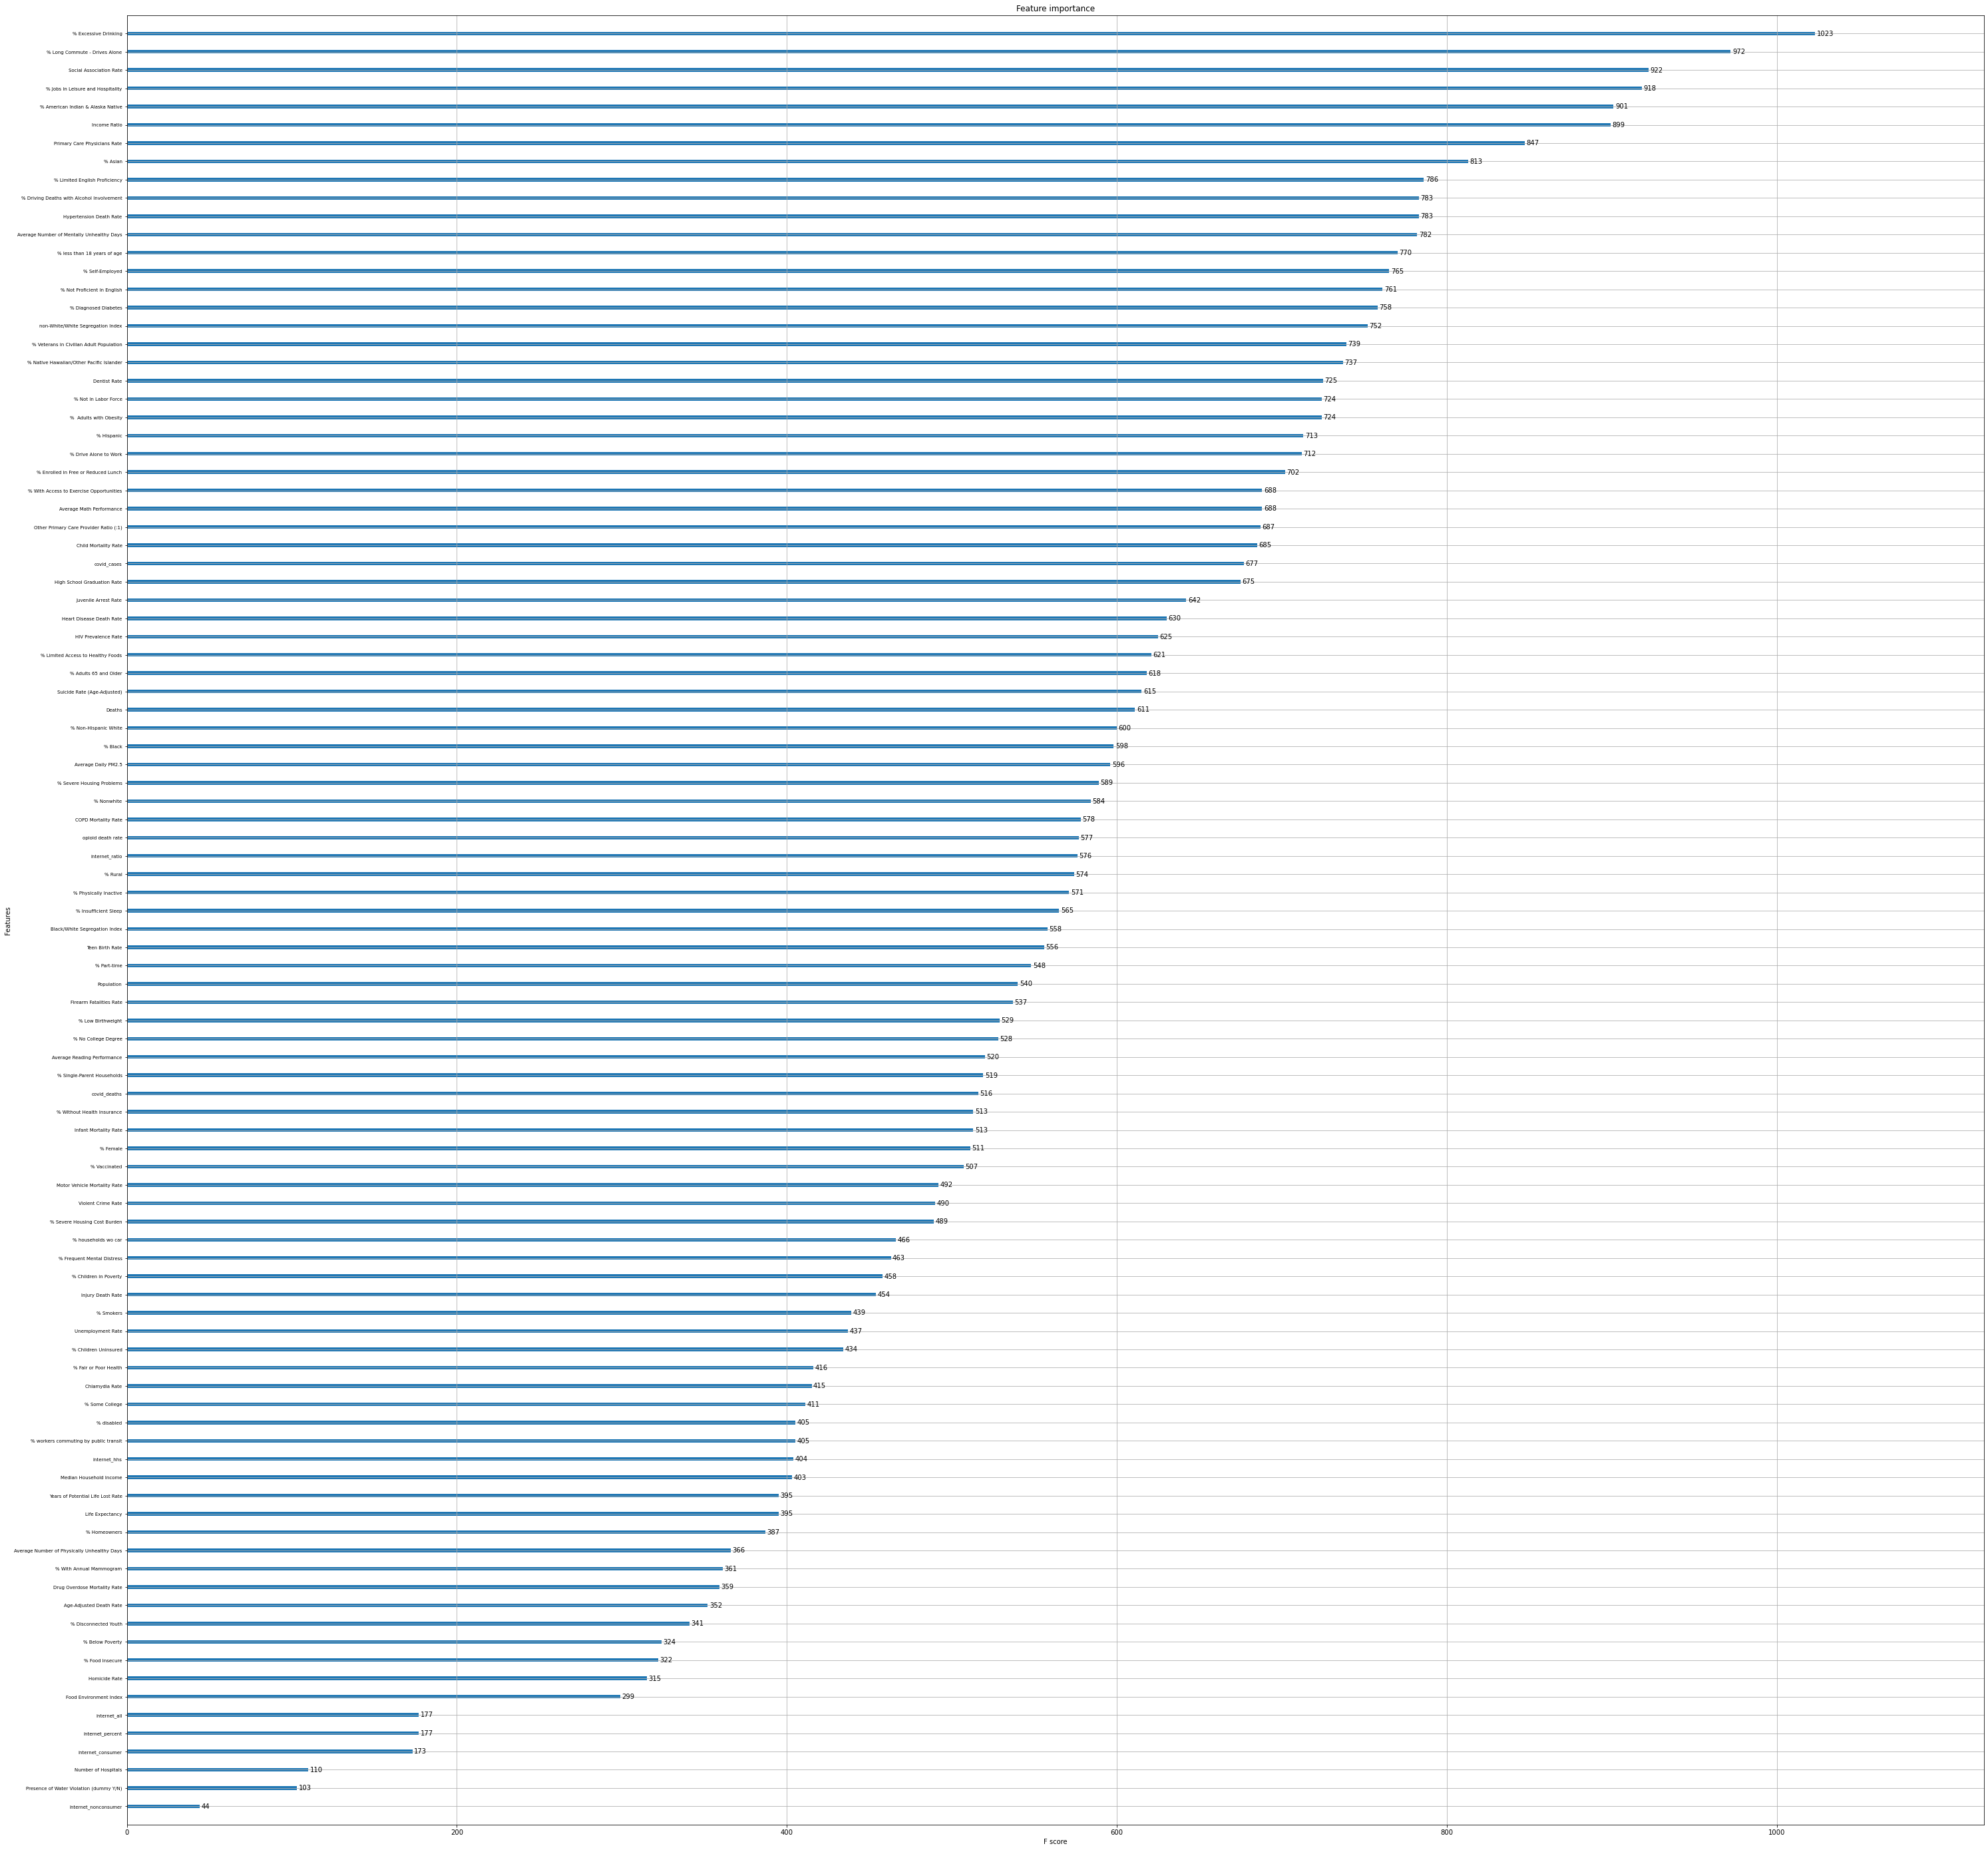

In [26]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [50, 50]
plt.yticks(size = 7)
plt.show()

### The following are the 8 most important features:
1. % Excessive Drinking
2. % Long Commute - Drives Alone
3. Social Association Rate
4. % Jobs in Leisure and Hospitality
5. % American Indian & Alaska Native
6. Income Ratio
7. Primary Care Physicians Rate
8. % Asian

### Correlation

In [27]:
X_x = X.filter(['% Jobs in Leisure and Hospitality', '% Excessive Drinking', 
                '% Long Commute - Drives Alone', '% Asian', 
                '% American Indian & Alaska Native', 'Income Ratio', 'Social Association Rate',
                'Primary Care Physicians Rate'])

In [28]:
Correlation_Matrix=X_x.corr().abs()
Correlation_Matrix

,% Jobs in Leisure and Hospitality,% Excessive Drinking,% Long Commute - Drives Alone,% Asian,% American Indian & Alaska Native,Income Ratio,Social Association Rate,Primary Care Physicians Rate
% Jobs in Leisure and Hospitality,1.000000,0.060395,0.001801,0.014911,0.011033,0.051002,0.054627,0.157713
% Excessive Drinking,0.060395,1.000000,0.038178,0.199343,0.084710,0.223120,0.050098,0.207235
% Long Commute - Drives Alone,0.001801,0.038178,1.000000,0.110844,0.122663,0.071209,0.305281,0.270739
% Asian,0.014911,0.199343,0.110844,1.000000,0.043127,0.078286,0.211905,0.329032
% American Indian & Alaska Native,0.011033,0.084710,0.122663,0.043127,1.000000,0.075588,0.078806,0.018102
Income Ratio,0.051002,0.223120,0.071209,0.078286,0.075588,1.000000,0.005735,0.085377
Social Association Rate,0.054627,0.050098,0.305281,0.211905,0.078806,0.005735,1.000000,0.128204
Primary Care Physicians Rate,0.157713,0.207235,0.270739,0.329032,0.018102,0.085377,0.128204,1.000000


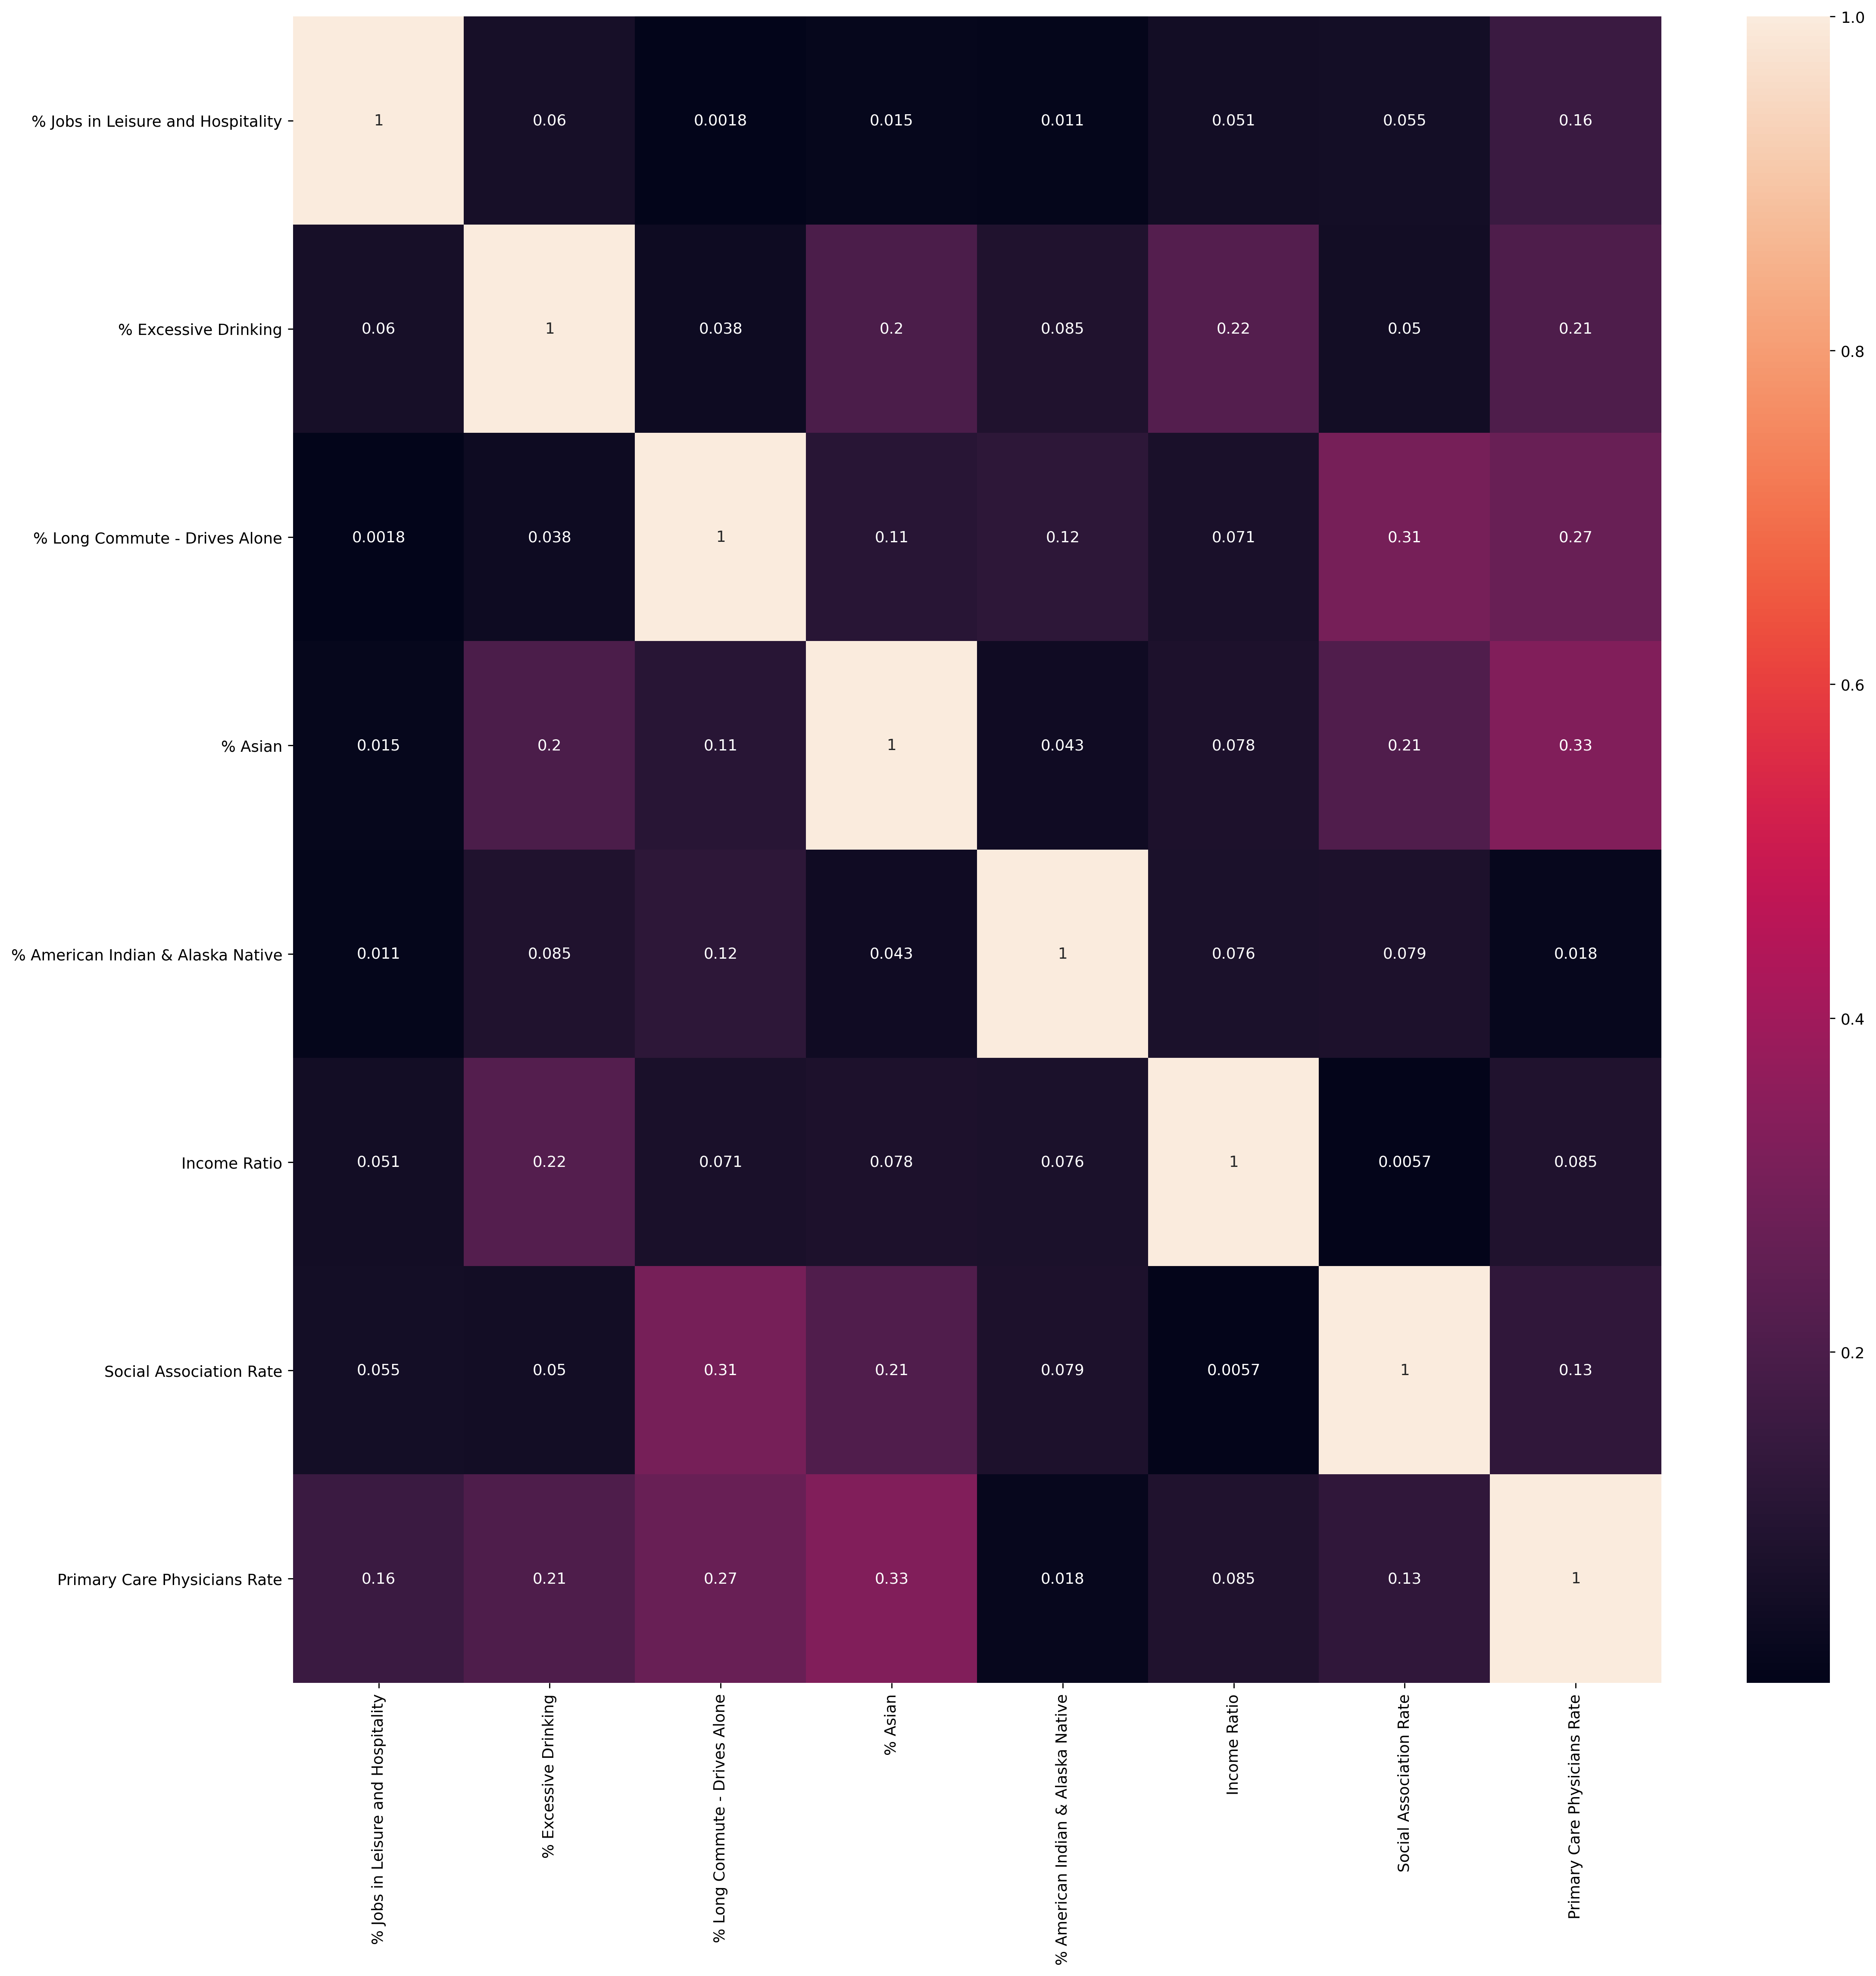

In [29]:
plt.figure(figsize=[20,20],dpi=256)
sns.heatmap(Correlation_Matrix, annot=True)

plt.show()

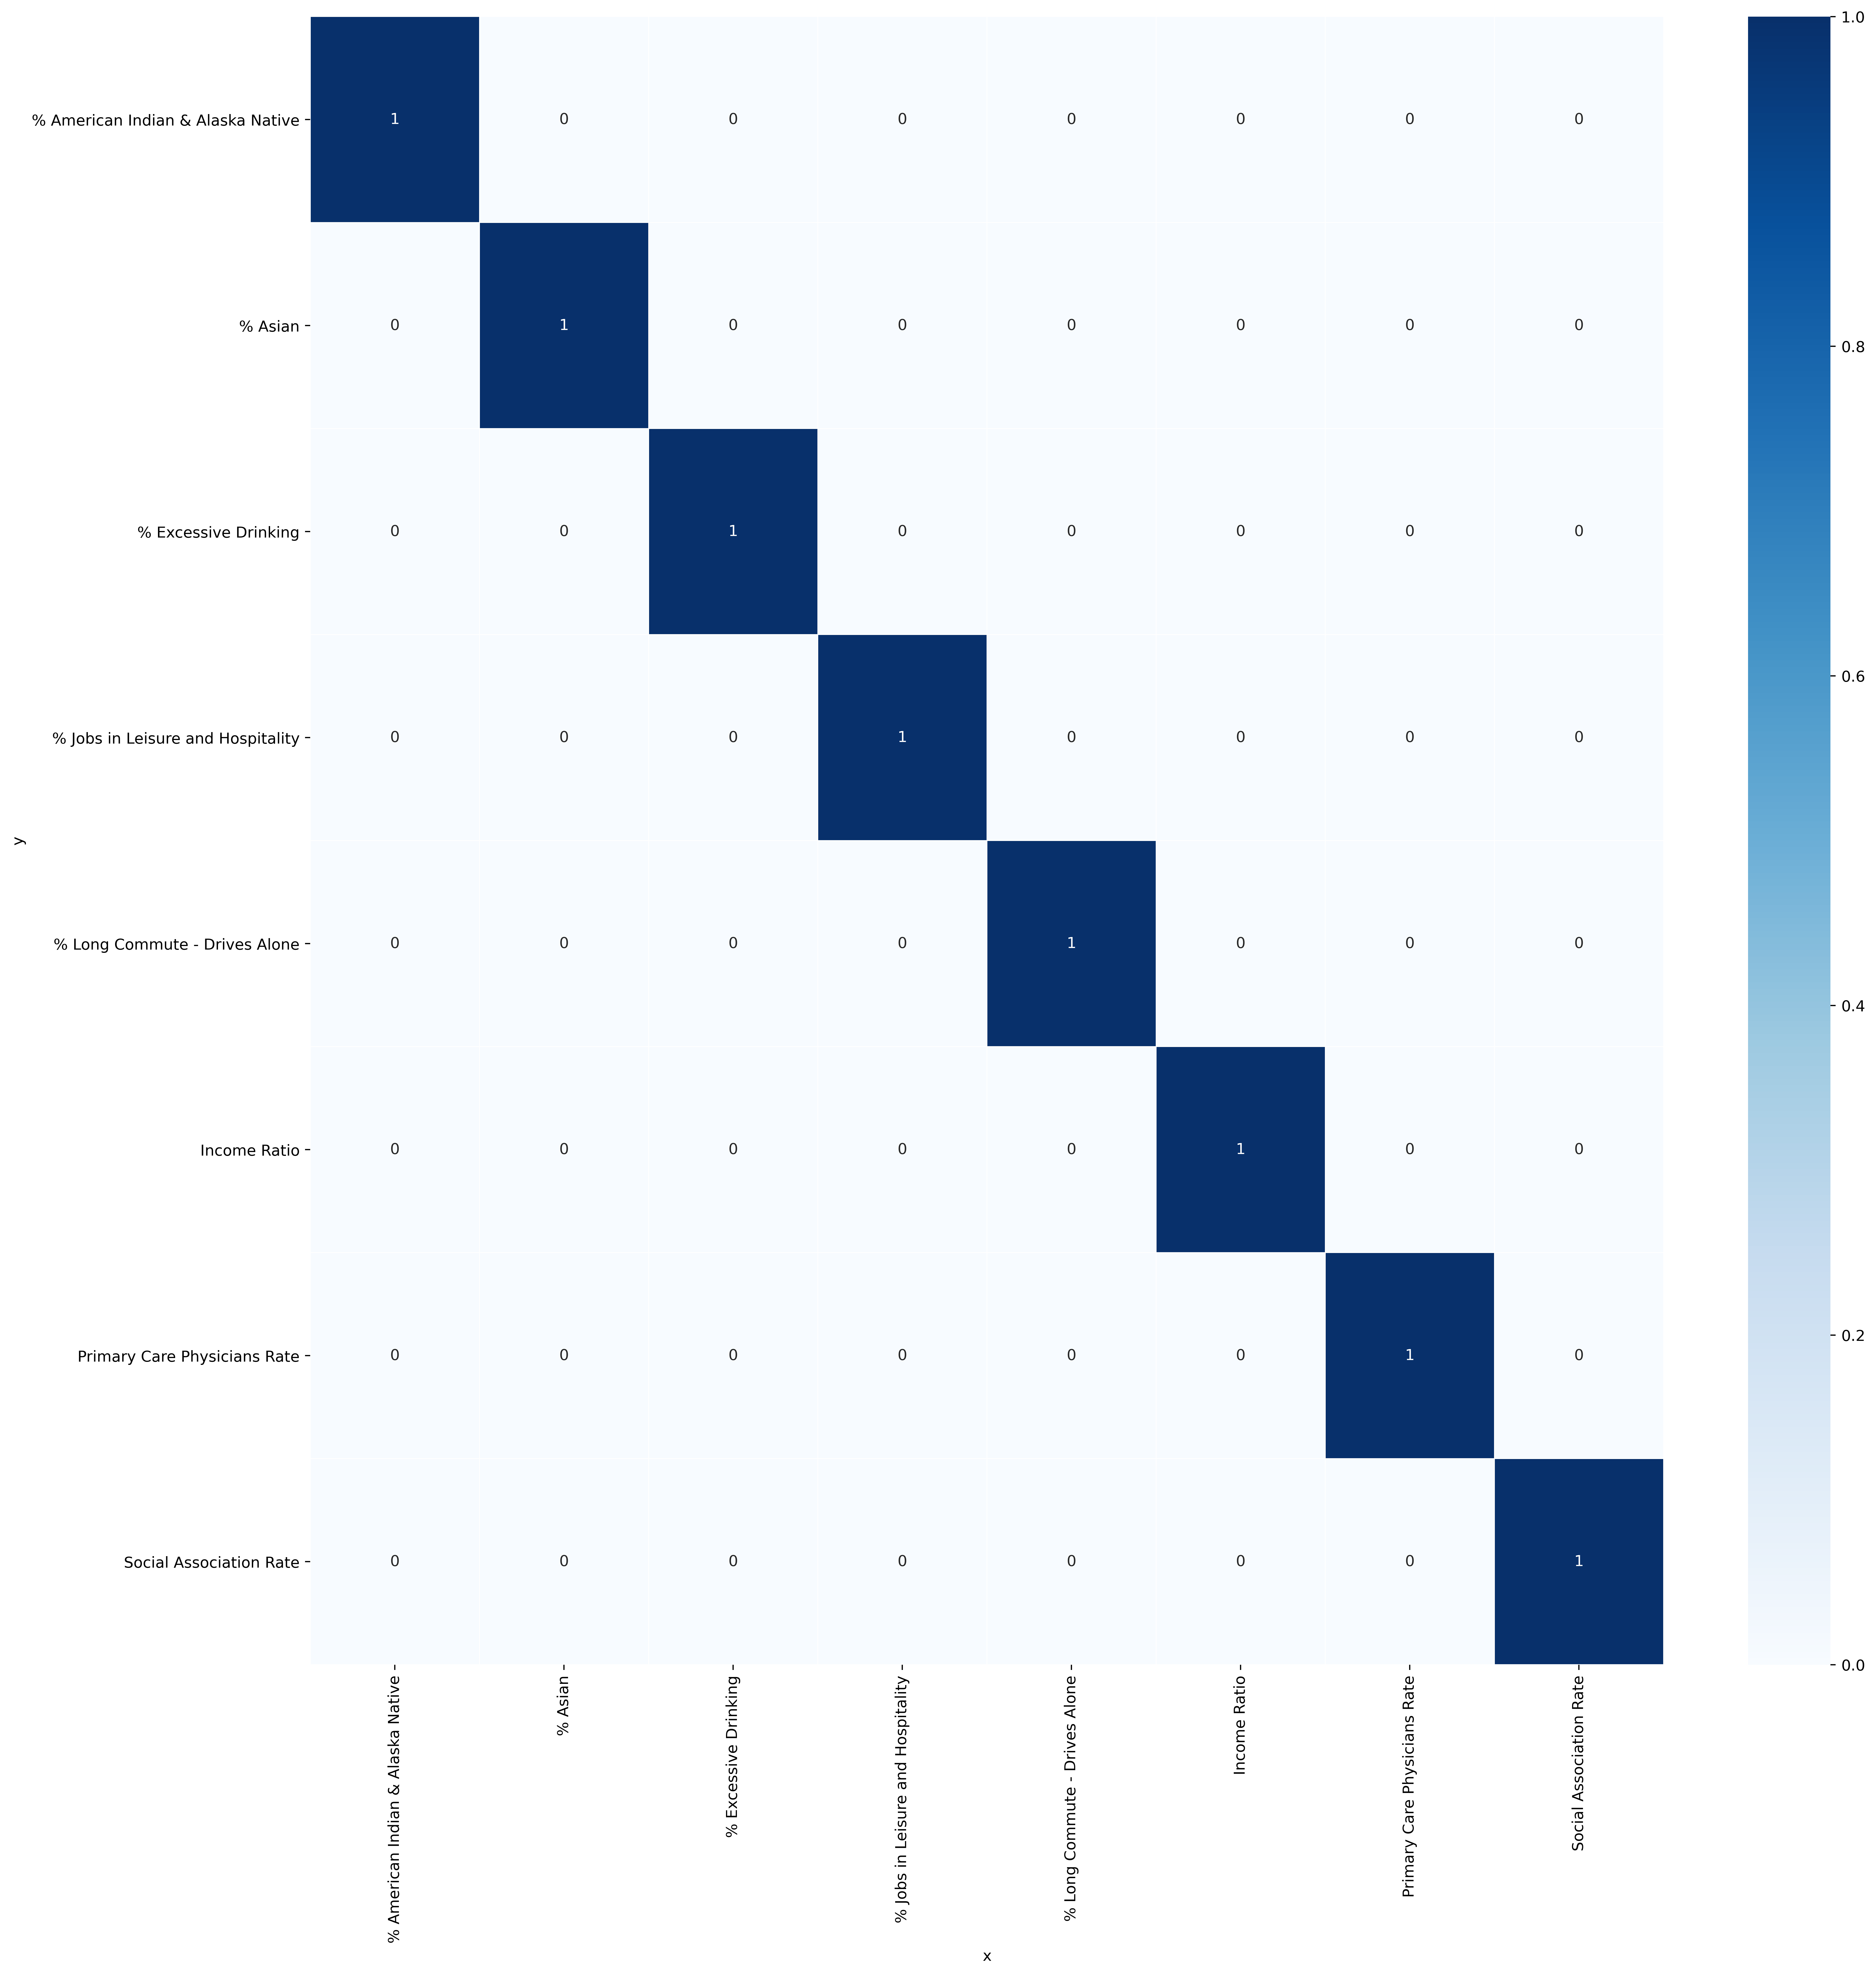

In [30]:
plt.figure(figsize=[20,20],dpi=400)
a = pps.matrix(X_x).pivot(columns='x', index='y', values='ppscore')
sns.heatmap(a, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.show()